Editing image...


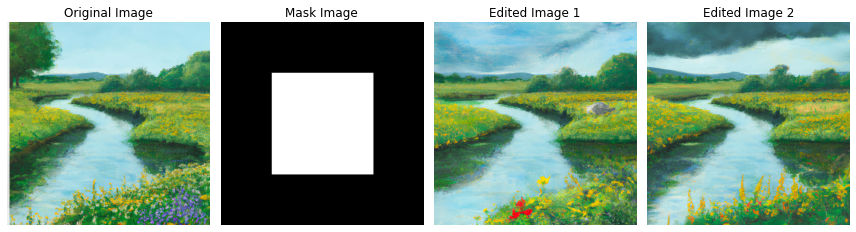

In [2]:
from openai import OpenAI
import requests
import datetime
from PIL import Image
from io import BytesIO
import os
import matplotlib.pyplot as plt

# Initialize the OpenAI client
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

def convert_mask_to_binary(mask_path):
    """Convert a mask image to binary (black and white)."""
    with Image.open(mask_path) as mask:
        mask = mask.convert("L")  # Convert to grayscale
        binary_mask = mask.point(lambda p: 255 if p > 128 else 0)  # Convert to binary
        return binary_mask

def edit_and_save_image(image_path, mask_path, prompt, filename, n=1):
    """Edit an image using a mask and return the edited images."""
    with Image.open(image_path) as img:
        size = (img.width, img.height)

    binary_mask = convert_mask_to_binary(mask_path)
    binary_mask = binary_mask.resize(size)

    os.makedirs("temp", exist_ok=True)
    resized_mask_path = 'temp/resized_binary_mask.png'
    binary_mask.save(resized_mask_path)

    print("Editing image...")
    response = client.images.edit(
        image=open(image_path, "rb"),
        mask=open(resized_mask_path, "rb"),
        prompt=prompt,
        n=n,
        size=f"{size[0]}x{size[1]}"
    )

    images = []
    for index, image_data in enumerate(response.data):
        image_url = image_data.url
        # print(image_url) # print if you want to see the image url
        image_content = requests.get(image_url).content
        edited_filename = f"{filename.split('.')[0]}_edit_{index}.png"
        with open(edited_filename, 'wb') as image_file:
            image_file.write(image_content)
        
        # Load image into PIL and append to list
        image = Image.open(BytesIO(image_content))
        images.append(image)
    
    return images

# Set parameters directly
n = 2
model = "dall-e-2"
image_path = "generated_images/example.png"
mask_path = "masks/example.png"
prompt = """
A dark and moody landscape painting reminiscent of Monet or Manet. 
The scene showcases a stormy countryside with a meandering river surrounded by vibrant greenery and blooming flowers.
"""

# Create directory for edited images
save_dir = "edited_images"
os.makedirs(save_dir, exist_ok=True)

# Edit and save images
fetched_name = image_path.split("/")[-1].split(".")[0]
save_path = f"{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}_edited_{fetched_name}.png"
save_path = os.path.join(save_dir, save_path)
images = edit_and_save_image(image_path, mask_path, prompt, save_path, n)

# Load the original image and mask
original_image = Image.open(image_path)
mask_image = Image.open(mask_path)

# Create a subplot with additional space for the original and mask images
fig, axes = plt.subplots(1, len(images) + 2, figsize=(12, 6))

# Display the original image
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the mask image
axes[1].imshow(mask_image, cmap='gray')
axes[1].set_title("Mask Image")
axes[1].axis('off')

# Display the edited images
for i, img in enumerate(images):
    axes[i + 2].imshow(img)
    axes[i + 2].set_title(f"Edited Image {i + 1}")
    axes[i + 2].axis('off')

plt.tight_layout()
plt.show()